In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers, models, Model
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from keras import backend

import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import cv2

C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
from pathlib import Path
import os
import seaborn as sns
from typing import Iterator, List, Union, Tuple
from datetime import datetime
from sklearn.model_selection import train_test_split

In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

## Load Data

In [7]:
def data_extraction(): 
    processed_path = Path(str(Path(os.getcwd()).parent.absolute())+'/PR_Sandbox/data_country_folders')
    country_list = sorted(processed_path.glob('*'))
    train_x, train_y, test_x, test_y, val_x, val_y = [], [], [], [], [], []
    data_array = []
    df_label = get_label_data()   
    for country in country_list:        
        data_list = sorted(country.glob('*.npy'))
        country_nme = str(country).split('\\')[-1]
        country_label = df_label.loc[country_nme]
        for i in data_list:
            year = str(i).split('_')[-1][:4]
            data_array = np.load(str(i.absolute()))
            data_array = cv2.resize(data_array, (600, 600))
            hist_3 = np.zeros((600,600, 3))
            hist_3[:,:,0] = data_array 
            hist_3[:,:,1] = data_array
            hist_3[:,:,2] = data_array
            if year < '2014':
                train_x.append(hist_3)
                train_y.append(country_label[year])
            elif year < '2015':
                val_x.append(hist_3)
                val_y.append(country_label[year])
            else:
                test_x.append(hist_3)
                test_y.append(country_label[year])

    return train_x, train_y, test_x, test_y, val_x, val_y


def get_label_data() -> pd.DataFrame:
    label_path = str(Path(os.getcwd()).parent.absolute()) + '/Yield_Data/all_country_crop_yield_tons_per_hectare.csv'
    df = pd.read_csv(label_path)
    df = df.set_index(['Country Name'])
#     df = df.drop(['Country Code','Indicator Name', 'Indicator Code', '2019','2020', '2021'], axis=1)
    return df

In [8]:
x_train,y_train,x_test,y_test, x_val, y_val = data_extraction()
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)


## Build Model

In [13]:
# calc a baseline to compare performance of efficient net and small cnn
def get_mean_baseline(y_train, y_test):
    df_train = pd.DataFrame(y_train, columns=['yield'])
    df_val = pd.DataFrame(y_test, columns=['yield'])
    y_hat = df_train['yield'].mean()
    df_val['y_hat']=y_hat
    mae = MeanAbsoluteError()
    mae = mae(df_val["yield"], df_val["y_hat"]).numpy()  
    mape = MeanAbsolutePercentageError()
    mape = mape(df_val["yield"], df_val["y_hat"]).numpy()
    print('Mean Absolute Error: ', mae)
    print("mean baseline MAPE: ", mape)
    return mape

# create image data generators for keras CNN input
def create_generators(x_train,y_train,x_test,y_test, x_val, y_val):
    train_generator = ImageDataGenerator() 
    
    validation_generator = ImageDataGenerator()     
    test_generator = ImageDataGenerator()
    
    train_generator = train_generator.flow(
        x_train,
        y_train,
        batch_size=4,
    )

    validation_generator = validation_generator.flow(
        x_val,
        y_val,
        batch_size=1,
    )
    test_generator = test_generator.flow(
        x_test,
        y_test,
        batch_size=1,
    )
    return train_generator, validation_generator, test_generator
    

In [6]:
# function to define metric for model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# function to initiate model building. Adapted from [1]
def run_model(model_name: str, model_function: Model, lr: float, train_generator: Iterator, validation_generator: Iterator, test_generator: Iterator) -> History:
    
    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()
    plot_model(model, to_file=model_name + ".jpg", show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), rmse]
    )
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=10, 
    )

    model.evaluate(
        test_generator,
        callbacks=callbacks,
    )
    return history, model

In [15]:
# function for callbacks, to implement early stopping and monitoring training process. Adapted from [1]
def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
    tensorboard_callback = TensorBoard(log_dir=logdir)
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=0.1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/" + model_name + ".h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]

In [5]:
# define structure of a small CNN to compare with efficient net
def small_cnn() -> Sequential:

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [4]:
# modify the output of efficient net by adding average pooling -> BN -> dropout -> Dense layers. Adapted from [1]
def adapt_efficient_net() -> Model:
   
    inputs = layers.Input(shape=(600, 600, 3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights=None)
#     # Freeze the pretrained weights
#     model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model

In [21]:
# function for plotting results and saving the history of both models to dataframe. Adapted from [1]
def plot_results(model_history_eff_net: History, mean_baseline: float):


    # create a dictionary for each model history and loss type
#     dict1 = {
#         "MAPE": model_history_small_cnn.history["mean_absolute_percentage_error"],
#         "RMSE": model_history_small_cnn.history["rmse"],
#         "type": "training",
#         "model": "small_cnn",
#     }
#     dict2 = {
#         "MAPE": model_history_small_cnn.history["val_mean_absolute_percentage_error"],
#         "RMSE": model_history_small_cnn.history["val_rmse"],
#         "type": "validation",
#         "model": "small_cnn",
#     }
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "RMSE": model_history_eff_net.history["rmse"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "RMSE": model_history_eff_net.history["val_rmse"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame
#     s1 = pd.DataFrame(dict1)
#     s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 300)) 
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()
    return df

In [19]:
mean_baseline = get_mean_baseline(y_train, y_val)
train_generator, validation_generator, test_generator = create_generators(x_train,y_train,x_test,y_test, x_val, y_val)
# small_cnn_history, cnn_model = run_model(
#     model_name="small_cnn",
#     model_function=small_cnn(),
#     lr=0.001,
#     train_generator=train_generator,
#     validation_generator=validation_generator,
#     test_generator=test_generator,
# )
eff_net_history, eff_model = run_model(
    model_name="eff_net",
    model_function=adapt_efficient_net(),
    lr=0.05,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)


Mean Absolute Error:  0.5369990468025208
mean baseline MAPE:  64.52413940429688
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
_______

C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
72/72 [==============================] - 494s 5s/step - loss: 2.8988 - mean_absolute_error: 2.8988 - mean_absolute_percentage_error: 358.3772 - rmse: 2.8988 - val_loss: 0.5034 - val_mean_absolute_error: 0.5034 - val_mean_absolute_percentage_error: 70.6419 - val_rmse: 0.5034
Epoch 2/100
72/72 [==============================] - 355s 5s/step - loss: 2.5363 - mean_absolute_error: 2.5363 - mean_absolute_percentage_error: 280.3476 - rmse: 2.5363 - val_loss: 158643312.0000 - val_mean_absolute_error: 158643312.0000 - val_mean_absolute_percentage_error: 17471490048.0000 - val_rmse: 158643312.0000
Epoch 3/100
72/72 [==============================] - 360s 5s/step - loss: 2.4171 - mean_absolute_error: 2.4171 - mean_absolute_percentage_error: 261.9531 - rmse: 2.4171 - val_loss: 13643352.0000 - val_mean_absolute_error: 13643352.0000 - val_mean_absolute_percentage_error: 1512528512.0000 - val_rmse: 13643352.0000
Epoch 4/100
72/72 [==============================] - 358s 5s/step - loss: 3.3

## Model Evaluation

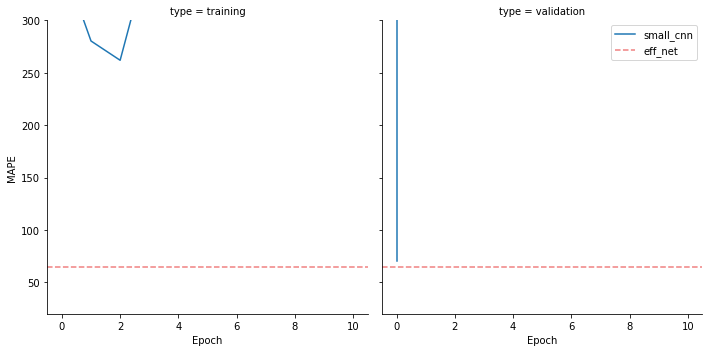

In [23]:
df = plot_results(eff_net_history, mean_baseline)

In [24]:
df

,index,MAPE,RMSE,type,model
0,0,3.583772e+02,2.898764e+00,training,eff_net
1,1,2.803476e+02,2.536301e+00,training,eff_net
2,2,2.619531e+02,2.417116e+00,training,eff_net
3,3,3.662866e+02,3.341809e+00,training,eff_net
4,4,4.405638e+02,3.930417e+00,training,eff_net
5,5,4.247002e+02,3.516340e+00,training,eff_net
6,6,4.022180e+02,3.600451e+00,training,eff_net
7,7,5.179103e+02,4.730671e+00,training,eff_net
8,8,4.253523e+02,3.805024e+00,training,eff_net
9,9,5.019464e+02,4.214326e+00,training,eff_net


In [25]:
print("EffNet MAPE on Validation data: ")
print((df['MAPE'].where(df['model']=='eff_net').where(df['type']=='validation')).min()/100)

EffNet MAPE on Validation data: 
0.7064192199707031


In [26]:
print("EffNet RMSE on Validation data: ")
print((df['RMSE'].where(df['model']=='eff_net').where(df['type']=='validation')).min())

EffNet RMSE on Validation data: 
0.5034223198890686


In [27]:
print("EffNet MAPE on Training data: ")
print((df['MAPE'].where(df['model']=='eff_net').where(df['type']=='training')).min()/100)

EffNet MAPE on Training data: 
2.6195306396484375


In [28]:
# print("Small CNN MAPE on Validation data: ")
# print(((df['MAPE'].where(df['model']=='small_cnn').where(df['type']=='validation')).min())/100)
# print("Small CNN MAPE on Training data: ")
# print((df['MAPE'].where(df['model']=='small_cnn').where(df['type']=='training')).min()/100)

In [29]:
# y_pred_cnn = cnn_model.predict(test_generator)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# valid_rmse = mean_squared_error(y_test, y_pred_cnn, squared=False)
# valid_mape = abs((y_test - y_pred_cnn) / y_test).mean()

In [31]:
# print("Small CNN MAPE on Test data: ",valid_mape)
# print("Small CNN RMSE on Test data: ", valid_rmse)

In [32]:
y_pred_eff = eff_model.predict(test_generator)

In [33]:
valid_rmse = mean_squared_error(y_test, y_pred_eff, squared=False)
valid_mape = abs((y_test - y_pred_eff) / y_test).mean()
print("EffNet MAPE on Test data: ",valid_mape)
print("Effnet RMSE on Test data: ", valid_rmse)

EffNet MAPE on Test data:  0.47836206308730805
Effnet RMSE on Test data:  0.5755451265713459


## References
[1].Markus Rosenfelder. Transfer learning with efficientnet for image regression in keras - using custom data in keras. https://rosenfelder.ai/keras-regression-efficient-net/, 2020